# kilojoule Library


In [1]:
from kilojoule.templates.default import *

air = idealgas.Properties('Air')
water = realfluid.Properties('Water')


## Units
The `kilojoule` library is designed to make use of dimensional "quantities" rather than simply doing calculations with numbers.  In engineering, all your calculations are using numbers to represent physical quantities and your calculations have no meaning without connection to appropriate units.  By including the physical units as an integral part of the calculation process, we keep the physical significance of our calculation in focus and will avoid costly mistakes from unit conversion errors.  To do this we will make use of the third-party library `pint` for managing units.  By executing the code in the block before this one, you have already loaded this library in the background; it is accessible through the `units` and `Quantity` objects.

We will first define a few property values, i.e. temperature and pressure

In [2]:
# The Q_(value,units) notation defines a physical quantity with a magnitude associated with a type of unit
T = Quantity(300.0,'degK')
print(T)
print(f'T = {T} = {T.to("degC")} = {T.to("degF")} = {T.to("degR")}')

p = Quantity(1.0,'atm')
print(f'p = {p} = {p.to("kPa")} = {p.to("Pa")} = {p.to("psi")} = {p.to("bar")}')


300.0 K
T = 300.0 K = 26.85 °C = 80.33 °F = 540.0 °R
p = 1.0 atm = 101.33 kPa = 1.0132×10⁵ Pa = 14.696 psi = 1.0133 bar


Notice that in the example above, we were able to access the quantities stored in the variables `T` and `p` in any unit system by using the notation `var.to("desired units")`.  We defined temperature in metric units, then displayed it in both alternate metric and English units.  Whereas we defined pressure in English units, then displayed it in both alternate English and metric units.  This system allows us to quickly switch back and forth between unit systems as needed.

The real benefit of this system is most evident when we start performing calculations with combined units.  In the following code we will calculate the change in energy of a mass that is changing temperature, velocity, and elevation.

\begin{align}\Delta E_{CV} &= m(\Delta u + \Delta ke + \Delta pe) \\&= m\left(u_2-u_1 + \frac{V_2^2}{2}-\frac{V_1^2}{2} + g(z_2-z_1)\right)\end{align}

In [3]:
m = Quantity(10.0,'kg')       # metric
u_1 = Quantity(300.0,'kJ/kg') # metric
u_2 = Quantity(200.0,'kJ/kg') # metric
Vel_1 = Quantity(20.0,'mph')  # English
Vel_2 = Quantity(30.5,'m/s')  # metric
g = Quantity(9.8,'m/s^2')     # metric
z_2 = Quantity(30.1,'ft')     # English
z_1 = Quantity(1.2,'m')       # metric

Delta_u = u_2-u_1
print(f"Delta u = {u_2} - {u_1} = {Delta_u}")

Delta_ke = (Vel_2**2-Vel_1**2)/2
print(f"Delta ke = {Vel_2**2/2} - {Vel_1**2/2} = {Delta_ke}")

Delta_pe = g*(z_2-z_1)
print(f"Delta pe = {g}({z_2}-{z_1}) = {Delta_pe}")

Delta_E_CV = m*(u_2-u_1 + (Vel_2**2-Vel_1**2)/2 + g*(z_2-z_1))
print(f"Delta E = {m}({Delta_u} + {Delta_ke} + {Delta_pe}) = {Delta_E_CV}")

Delta u = 200.0 kJ/kg - 300.0 kJ/kg = -100.0 kJ/kg
Delta ke = 465.12 m²/s² - 200.0 mph² = 425.16 m²/s²
Delta pe = 9.8 m/s²(30.1 ft-1.2 m) = 256.4 ft·m/s²
Delta E = 10.0 kg(-100.0 kJ/kg + 425.16 m²/s² + 256.4 ft·m/s²) = -994.97 kJ


Notice that in the above example, the units for each of the terms were in different systems until they were combined.  

## States Database
Many of the systems we will be analyzing will have many states with multiple properties of interest at each state.  Keeping track of the these states and properties in a consistent, organized manner will make your code cleaner and easier to maintain.  To aid in this, the `kilojoule` library provides a data structure designed specifically for this purpose.  The `PropertyTable` behaves similarly to a nested Python dictionary.  You can view the data structure as a table with columns representing properties and rows representing states.  Each property column has a defined unit that will apply to all it's values, i.e. all temperatures stored in $^\circ\text{C}$.  We first need to import the `PropertyTable` class from the `kilojoule` module. *(Note: this will already be loaded if you recently executed the first code block in this notebook)*

In [4]:
from kilojoule.organization import PropertyTable

We can now initialize our states database (`PropertyTable(...)`) and store it in a variable where we can easily access it (`states = ...`).  There are a few ways to fill out the table columns with properties and units, but the most straight forward way (apart from using one of the provided templates) is to make a dictionary with the desired properties as keys associated with the appropriate units (`properties_dict = {'property symbol':'units', ...}`).

In [5]:
# Make a dictionary with the types of properties you want to track and units for each property
properties_dict = {
    'T':'degC',
    'p':'kPa',
    'v':'m^3/kg',
    'h':'kJ/kg',
    's':'kJ/kg/K',
    'x':' '
}

# Make a database to hold the property values for each state and store in the variable name `states`
states = PropertyTable(properties=properties_dict)

# The states container is initially empty
print(states)

Empty DataFrame
Columns: []
Index: []


The table will initially be empty, be we can add properties values for different states to it on the fly.  Recall that we defined preferred units for each of the property columns.  In the example below we will define some temperatures and pressures in consistent units, inconsistent units, and with missing units.

In [6]:
states[1,'T'] = Quantity(30,'degC') # consistent units
states[2,'p'] = Quantity(1,'atm')   # inconsistent units (will be converted kPa)
states[3,'T'] = 100           # missing units (assumed to be degC)
states[3,'p'] = 200           # missing units (assumed to be kPa)

print(states)


        T        p
unit   °C      kPa
1      30        -
2       -  101.325
3     100      200


Notice that we originally defined the temperature column to have units of $^\circ\text{C}$, then we explicitly defined a temperature quantity with units of $^\circ\text{C}$ and placed it in state 1 in the temperature column (`states[state, property] = value`).  We then defined a pressure for state 2, but we used an inconsistent unit, i.e. we defined it in $\text{atm}$ when the column expected $\text{kPa}$.  When we view the contents of the states database (`print(states)`) we see that then pressure value at state 2 was automatically converted to $\text{kPa}$.  Finally we defined a temperature and pressure for state 3 without explicitly stating the units.  When this happens, it will be assumed that the values are already in the preferred units.  While this makes the syntax shorter, it is not a good practice since changes in other parts of the code could have unexpected consequences.

An alternate (shorter) syntax for working with the values in the table can be enabled by assigning each column in the table to a variable in the local namespace.  After executing the code below, we will be able to set the quality at state 2 to 50% with the code {`x[2] = 0.5`} rather than needing to type {`states[1,'x'] = 0.5`}

In [7]:
# The following lines will define (overwrite) convenience variables in the local namespace for each of the properties in the states container
# This allows you to add values to (or pull values from) the database using the nomenclature T[1], T[2], p[3], etc.
for property in states.properties:
    globals()[property] = states.dict[property]

x[2] = 0.5
T['inlet'] = Quantity(25,'degC')
print(states)

         T        p    x
unit    °C      kPa     
1       30        -    -
2        -  101.325  0.5
3      100      200    -
inlet   25        -    -


The preferred units for each property column can be changed at any time using the `.set_units()` method and all values in that column will be automatically converted to the new units

In [8]:
states.display() 

T.set_units('degF')
p.set_units('psi')
states.display()

T.set_units('K')
p.set_units('Pa')
states.display()

T.set_units('degC')
p.set_units('kPa')
states.display()

,T,p,x
unit,°C,kPa,
1,30,-,-
2,-,101.325,0.5
3,100,200,-
inlet,25,-,-


,T,p,x
unit,°F,psi,
1,86,-,-
2,-,14.6959,0.5
3,212,29.0075,-
inlet,77,-,-


,T,p,x
unit,K,Pa,
1,303.15,-,-
2,-,101325,0.5
3,373.15,200000,-
inlet,298.15,-,-


,T,p,x
unit,°C,kPa,
1,30,-,-
2,-,101.325,0.5
3,100,200,-
inlet,25,-,-


## Properties
The `kilojoule` library provides wrapper to evaluate properties using the `CoolProp` Library (which also has interfaces for other languages besides Python) and the PYroMat library.  Both of these libraries can be used directly.  However, the wrappers provided by the `kilojoule` package incorporate the `pint` package to handle a wider range of units and also rename a number of parameters to be consistent with the nomenclature commonly used in mechanical engineering textbooks.

### Water Properties
In the first code block at the top of this notebook, you imported the `realfluid.Properties` class from the `kilojoule` library as part of the default template.  We can use this object to evaluate the properties of a number of real (*pure/pseudopure*) fluids.  You may already be familiar with looking up properties for water from the tables from your Thermo I course.  Recall that for a pure substance you need two independent, intensive properties to fix a state, i.e. if you know two independent properties you can find any other property that you need for the state *(Note: there is a little more to the story here, but we will get to that later in the course)*.  For now, let's say we have water at $T_1=300^\circ\text{C}$ and $p_1=750\,\text{kPa}$ and we would like to find the specific volume, $v$, specific internal energy, $u$, specific enthalpy, $h$, and  specific entropy, $s$.  For each of these cases, we could say the desired (dependent) property is a function of the two known (independent) properties:
$$v_1 = v(T=300^\circ\text{C}, p=750\,\text{kPa})$$
$$u_1 = u(T=300^\circ\text{C}, p=750\,\text{kPa})$$
$$h_1 = h(T=300^\circ\text{C}, p=750\,\text{kPa})$$
$$s_1 = s(T=300^\circ\text{C}, p=750\,\text{kPa})$$
In order to use the `kilojoule.realfluid.Properties` class, we first need to instantiate it (Python-speak for initialize the class and store in a variable).  The following code block will import the class (if needed), set the target fluid to be water, and set the default unit system to be metric with temperatures in $^\circ\text{C}$

In [9]:
from kilojoule.templates.default import *
from kilojoule import realfluid

water = realfluid.Properties('Water', unit_system='SI_C') # the default unit_system is 'SI_C' other options are 'SI_K', 'English_F', and 'English_R'

The `water` object now has sub-functions (or methods) that can be used to evaluate (look up) dependent properties.

In [10]:
# Define known values (independent properties)
T[1] = Quantity(300,'degC')
p[1] = Quantity(750,'kPa')

# specific volume
v[1] = water.v(T=T[1], p=p[1])

# specific internal energy
u[1] = water.u(T=T[1], p=p[1])

# specific enthalpy
h[1] = water.h(T=T[1], p=p[1])

# specific entropy
s[1] = water.s(T=T[1], p=p[1])

# phase
phase[1] = water.phase(T=T[1], p=p[1])

states.display()


,T,p,v,u,h,s,phase
unit,°C,kPa,m³/kg,kJ/kg,kJ/kg,kJ/K/kg,
1,300,750,0.346214,2798.496371,3058.156633,7.26594,gas


We can also use the same functions for evaluating the properties of saturated fluids.  Let's assume the fluid from state 1 in the above example is cooled at a constant pressure until it is entirely in liquid form, i.e. $x_2=0$.  We could then find all the remaining properties at state 2 as well.
$$ p_2 = p_1 $$
$$ T_2 = T(p=p_2, x=x_2) $$
$$ v_2 = v(p=p_2, x=x_2) $$
$$ u_2 = u(p=p_2, x=x_2) $$
$$ h_2 = h(p=p_2, x=x_2) $$
$$ s_2 = x(p=p_2, x=x_2) $$

In [11]:
p[2] = p[1]
x[2] = 0

T[2] = water.T(p=p[2], x=x[2])
v[2] = water.v(p=p[2], x=x[2])
u[2] = water.u(p=p[2], x=x[2])
h[2] = water.h(p=p[2], x=x[2])
s[2] = water.s(p=p[2], x=x[2])
phase[2] = water.phase(p=p[2], x=x[2])

states.display()

,T,p,v,u,h,s,x,phase
unit,°C,kPa,m³/kg,kJ/kg,kJ/kg,kJ/K/kg,,
1,300.000000,750,0.346214,2798.496371,3058.156633,7.265940,-,gas
2,167.748559,750,0.001111,708.401761,709.235334,2.019482,0,twophase


Notice that the phase for state 2 is reported as `twophase`, even though we know it is entirely liquid because the quality is 0.  This state would be more accurately described as a saturated-liquid, but the `CoolProp` library reports all saturated states (saturate liquid, saturated mixture, and saturated vapor) as `twophase`.  

Let's now calculate a third state the would be obtained from an isenthalpic expansion to $p_3=100\,\text{kPa}$ resulting in a saturated mixture.
$$ h_3 = h_2 $$
$$ p_3 = 100\,\text{kPa} $$
$$ T_3 = T(p=p_3, h=h_3) $$
$$ v_3 = v(p=p_3, h=h_3) $$
$$ u_3 = u(p=p_3, h=h_3) $$
$$ x_3 = x(p=p_3, h=h_3) $$
$$ s_3 = x(p=p_3, h=h_3) $$

In [12]:
h[3] = h[2]
p[3] = Quantity(100,'kPa')

T[3] = water.T(p=p[3], h=h[3])
v[3] = water.v(p=p[3], h=h[3])
u[3] = water.u(p=p[3], h=h[3])
x[3] = water.x(p=p[3], h=h[3])
s[3] = water.s(p=p[3], h=h[3])
phase[3] = water.phase(p=p[3], h=h[3])

states.display()

,T,p,v,u,h,s,x,phase
unit,°C,kPa,m³/kg,kJ/kg,kJ/kg,kJ/K/kg,,
1,300.000000,750,0.346214,2798.496371,3058.156633,7.265940,-,gas
2,167.748559,750,0.001111,708.401761,709.235334,2.019482,0,twophase
3,99.605929,100,0.219816,687.253725,709.235334,2.085392,0.129231,twophase


#### Plotting Property Diagrams
It is often helpful to visualize processes by plotting the states on property diagrams, i.e. $T$-$s$, $p$-$v$, $p$-$h$, etc.  The `kilojoule` library provides a `property_diagram` class for each fluid (both real fluids and ideal gases) that can be used to create common property diagrams used in thermodynamics.  This class uses the popular `matplotlib` library.  You first instantiate the class with the properties for the $x$ and $y$ axes, the unit system (if not using the default of SI with $^\circ\text{C}$), and the type of fluid.  You can also set the `saturation` parameter to `True` if you want to show the saturation curves.  

In the following code, we will store this plot (instance of the FluidPropertyPlot class) in the variable `Ts_diagram`. 
> `Ts_diagram = water.property_diagram(x='s', y='T', unit_system='English_F', fluid='Water', saturation=True)`

The `Ts_diagram` object contains a `matplotlib` figure and axis stored as attributes accessible at `Ts_diagram.fig` and `Ts_diagram.ax`.  We can use any `matplotlib` functions on these objects to add features to the diagram (many examples are available on the internet).  However, there are a few custom `matplotlib` routines built into the `PropertyPlot` class, which will make it easier to show our processes.  

The simplest built-in construct is the `.plot_point(x, y, label='label', label_loc='north')` method, which places a dot at the $x$, $y$ coordinates with an optional label placed at the relative location provided (default is north)
> `Ts_diagram.plot_point(x=s[1], y=T[1], label'1', label_loc='north')`

An alternate interface is also available if your data is stored in the `PropertyTable()` class described above.
> `Ts_diagram.plot_state(states[2])`  
> `Ts_diagram.plot_state(states[3])`

We would like to draw lines connecting the states to illustrate the process.  However, we do not want to simply draw straight lines connecting the points.  Rather, we would like the path of the line to represent the process properties at all points.  We can do this if we know something that was constant during the process, ie. pressure was constant from 1 to 2 and enthalpy was constant from 2 to 3 in our earlier example.  The `.plot_process()` method accepts two states and a path description to achieve this:
>`Ts_diagram.plot_process(states[1], states[2], path='isobaric')`  
>`Ts_diagram.plot_process(states[2], states[3], path='isenthalpic')`

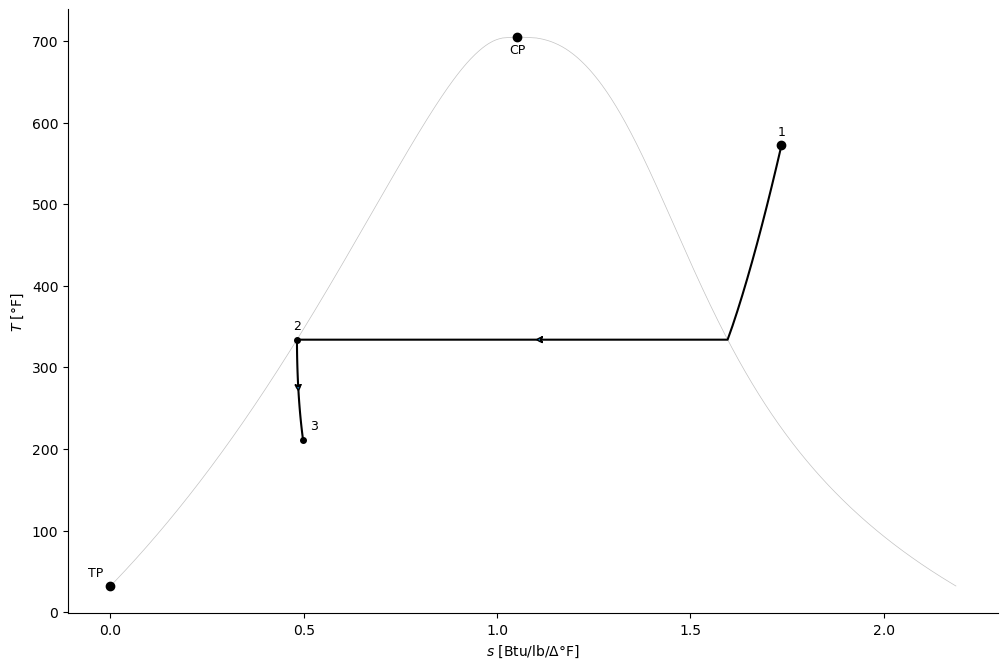

In [13]:
# Create Ts_diagram instance
Ts_diagram = water.property_diagram(x='s', y='T', unit_system='English_F', saturation=True)

# Plot Critial and Triple Points
Ts_diagram.plot_triple_point(label='TP',label_loc='northwest')
Ts_diagram.plot_critical_point(label_loc='south')

# Plot State 1 using the .plot_point() method
Ts_diagram.plot_point(x=s[1], y=T[1], label='1', label_loc='north')

# Plot States 2 and 3 using the .plot_state() method
Ts_diagram.plot_state(states[2])
Ts_diagram.plot_state(states[3], label_loc='north east')

# Connect the states with lines that illustrate the process paths
Ts_diagram.plot_process(states[1], states[2], path='isobaric')
Ts_diagram.plot_process(states[2], states[3], path='isenthalpic');

We can use this same process to also create additional plots for our system by changing the parameters when we instantiate the `property_diagram` class.  *Note: a number of common x and y combinations have shortcut defined for them, i.e. Ts, pv, Tv, hs, ph, and pT*

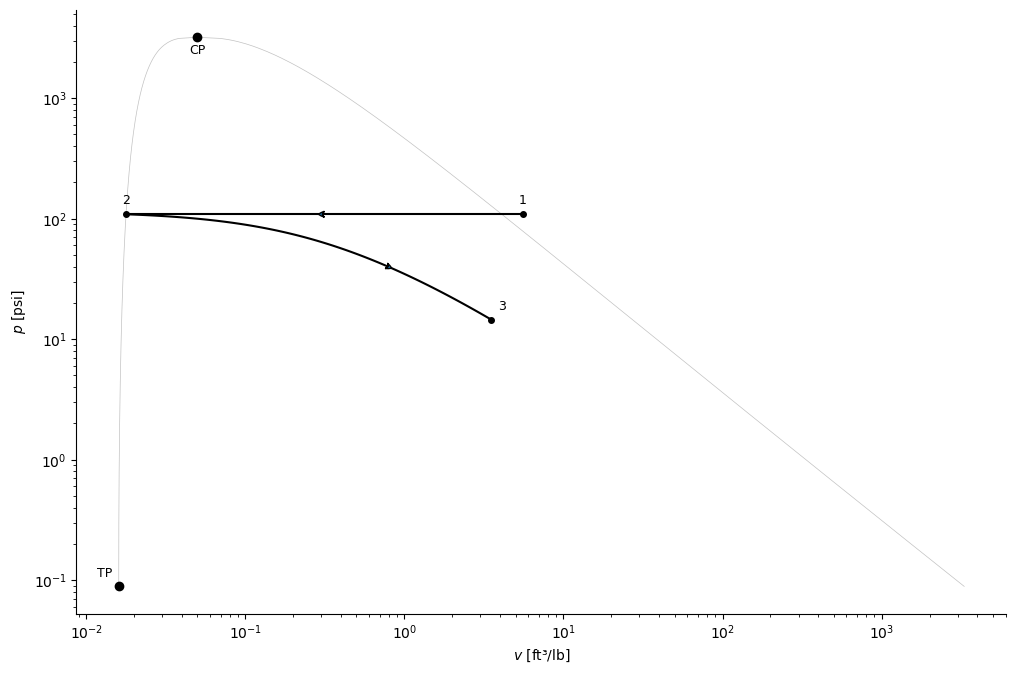

In [14]:
# Create pv_diagram instance
pv_diagram = water.pv_diagram(saturation=True) # Note: this is the only line that will be changed for the next few examples
# Plot Critial and Triple Points
pv_diagram.plot_triple_point(label='TP',label_loc='northwest')
pv_diagram.plot_critical_point(label_loc='south')
# Plot States 1-3 using the .plot_state() method
pv_diagram.plot_state(states[1])
pv_diagram.plot_state(states[2])
pv_diagram.plot_state(states[3], label_loc='north east')
# Connect the states with lines that illustrate the process paths
pv_diagram.plot_process(states[1], states[2], path='isobaric')
pv_diagram.plot_process(states[2], states[3], path='isenthalpic');

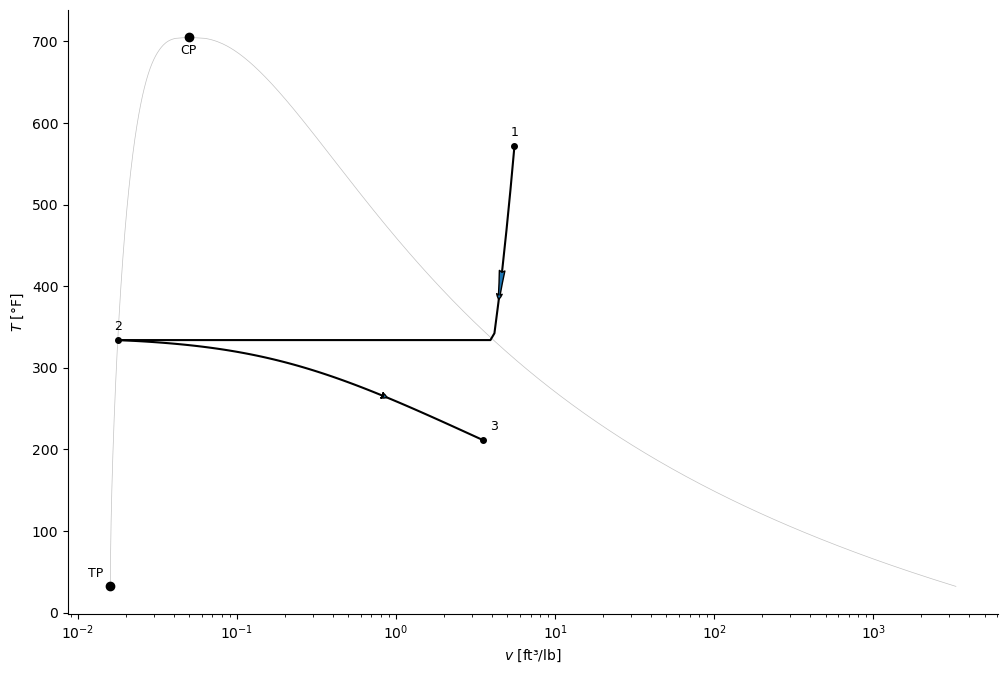

In [15]:
# Create Tv_diagram instance
Tv_diagram = water.Tv_diagram(saturation=True) # Note: this is the only that line was changed
# Plot Critial and Triple Points
Tv_diagram.plot_triple_point(label='TP',label_loc='northwest')
Tv_diagram.plot_critical_point(label_loc='south')
# Plot States 1-3 using the .plot_state() method
Tv_diagram.plot_state(states[1])
Tv_diagram.plot_state(states[2])
Tv_diagram.plot_state(states[3],label_loc='north east')
# Connect the states with lines that illustrate the process paths
Tv_diagram.plot_process(states[1], states[2], path='isobaric')
Tv_diagram.plot_process(states[2], states[3], path='isenthalpic');

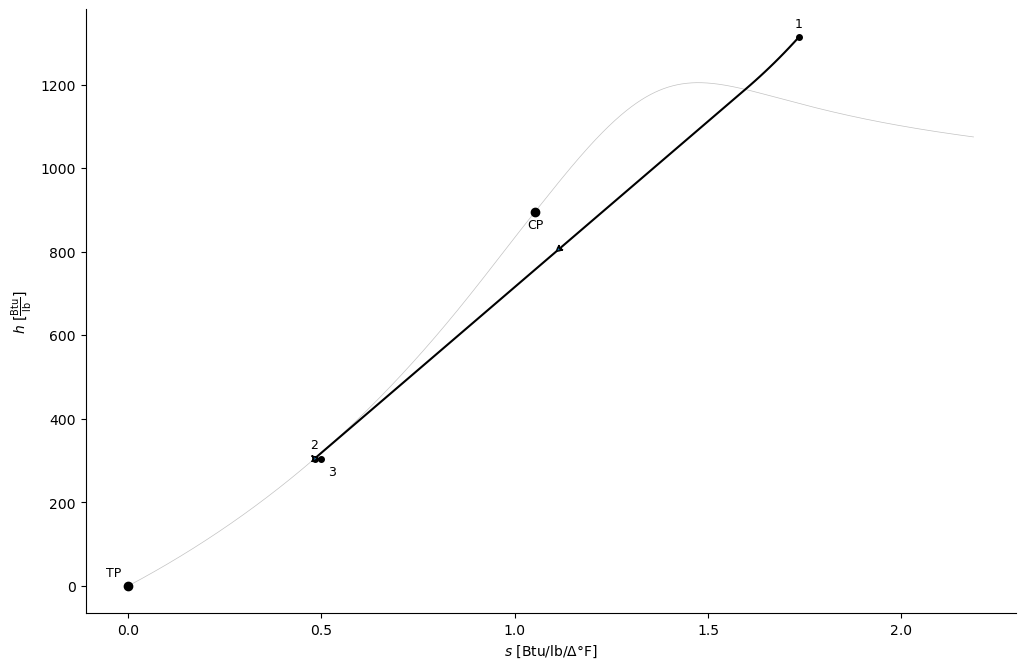

In [16]:
# Create hs_diagram instance
hs_diagram = water.hs_diagram(saturation=True) # Note: this is the only line that was changed
# Plot Critial and Triple Points
hs_diagram.plot_triple_point(label='TP',label_loc='northwest')
hs_diagram.plot_critical_point(label_loc='south')
# Plot States 1-3 using the .plot_state() method
hs_diagram.plot_state(states[1])
hs_diagram.plot_state(states[2])
hs_diagram.plot_state(states[3], label_loc='southeast')
# Connect the states with lines that illustrate the process paths
hs_diagram.plot_process(states[1], states[2], path='isobaric')
hs_diagram.plot_process(states[2], states[3], path='isenthalpic');

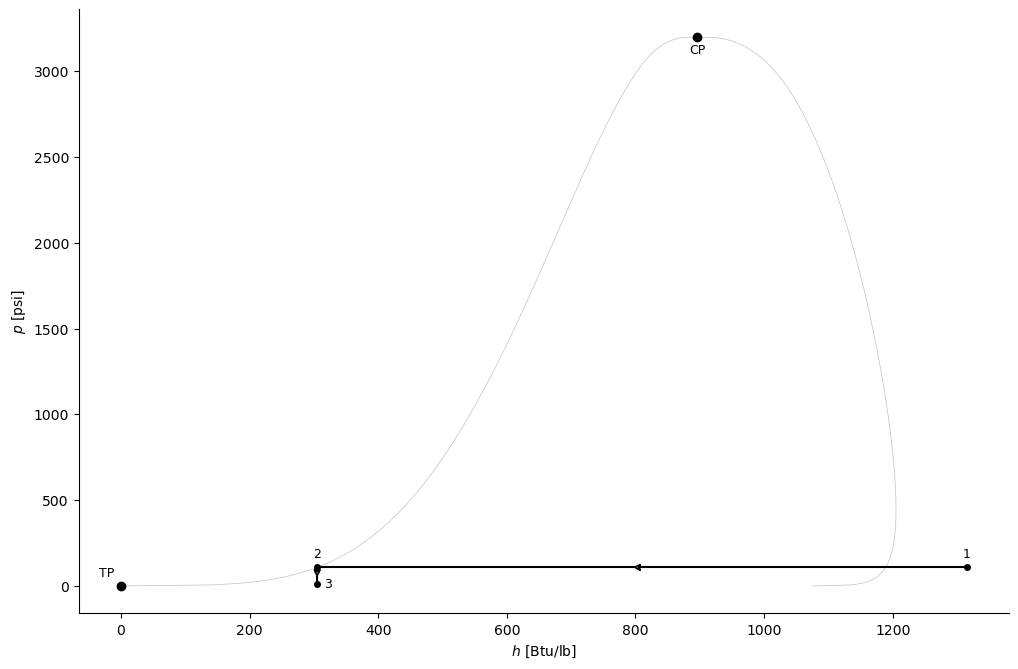

In [17]:
# Create Tv_diagram instance
ph_diagram = water.ph_diagram(saturation=True) # Note: this is the only line that was changed
# Plot Critial and Triple Points
ph_diagram.plot_triple_point(label='TP',label_loc='northwest')
ph_diagram.plot_critical_point(label_loc='south')
# Plot States 1-3 using the .plot_state() method
ph_diagram.plot_state(states[1])
ph_diagram.plot_state(states[2])
ph_diagram.plot_state(states[3], label_loc='east')
# Connect the states with lines that illustrate the process paths
ph_diagram.plot_process(states[1], states[2], path='isobaric')
ph_diagram.plot_process(states[2], states[3], path='isenthalpic');

The ability to generate the previous 5 diagrams using the same set of commands (with only minor changes to the first line) provides a excellent opportunity to write a loop to decrease the amount of code you need to write and maintain.

### Refrigerant Properties
All the commands demonstrated above will also work for any of the other pure/pseudopure substances, such as R-134a, supported by the underlying CoolProps library, a list of which can be obtained with the following code.

In [18]:
from CoolProp.CoolProp import FluidsList
FluidsList()

['1-Butene',
 'Acetone',
 'Air',
 'Ammonia',
 'Argon',
 'Benzene',
 'CarbonDioxide',
 'CarbonMonoxide',
 'CarbonylSulfide',
 'cis-2-Butene',
 'CycloHexane',
 'Cyclopentane',
 'CycloPropane',
 'D4',
 'D5',
 'D6',
 'Deuterium',
 'Dichloroethane',
 'DiethylEther',
 'DimethylCarbonate',
 'DimethylEther',
 'Ethane',
 'Ethanol',
 'EthylBenzene',
 'Ethylene',
 'EthyleneOxide',
 'Fluorine',
 'HeavyWater',
 'Helium',
 'HFE143m',
 'Hydrogen',
 'HydrogenChloride',
 'HydrogenSulfide',
 'IsoButane',
 'IsoButene',
 'Isohexane',
 'Isopentane',
 'Krypton',
 'm-Xylene',
 'MD2M',
 'MD3M',
 'MD4M',
 'MDM',
 'Methane',
 'Methanol',
 'MethylLinoleate',
 'MethylLinolenate',
 'MethylOleate',
 'MethylPalmitate',
 'MethylStearate',
 'MM',
 'n-Butane',
 'n-Decane',
 'n-Dodecane',
 'n-Heptane',
 'n-Hexane',
 'n-Nonane',
 'n-Octane',
 'n-Pentane',
 'n-Propane',
 'n-Undecane',
 'Neon',
 'Neopentane',
 'Nitrogen',
 'NitrousOxide',
 'Novec649',
 'o-Xylene',
 'OrthoDeuterium',
 'OrthoHydrogen',
 'Oxygen',
 'p-Xylene'

To obtain properties for any of the supported fluids, simply supply the appropriate name when you instantiate the `realfluid.Properties()` class, i.e.

h_ref = 285.0 kJ/kg
v_ref = 0.007292 m³/kg
s_ref = 1.2862 kJ/kg/Δ°C


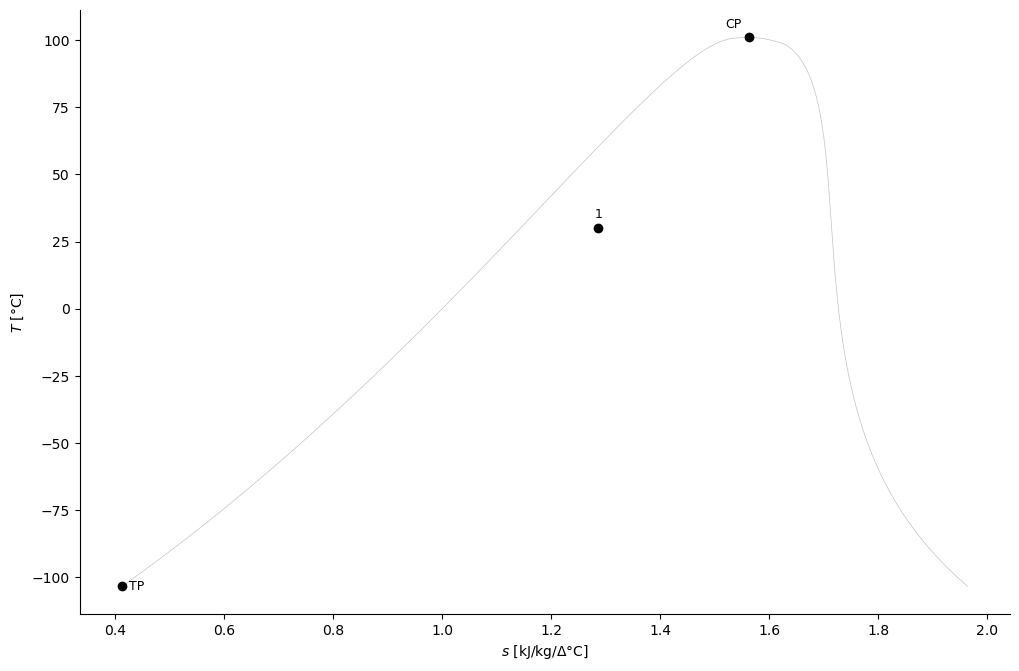

In [19]:
r134a = realfluid.Properties('R134a')
T_ref = Quantity(30,'degC')
x_ref = Quantity(0.25,' ')              # Note: quality is dimensionless, so we define its units as an empty string

h_ref = r134a.h(T=T_ref, x=x_ref)
print(f'h_ref = {h_ref}')

v_ref = r134a.v(T=T_ref, x=x_ref)
print(f'v_ref = {v_ref}')

s_ref = r134a.s(T=T_ref, x=x_ref)
print(f's_ref = {s_ref}')

Ts_diagram = r134a.Ts_diagram(saturation=True)
Ts_diagram.plot_triple_point()
Ts_diagram.plot_critical_point()
Ts_diagram.plot_point(x=s_ref, y=T_ref, label='1');


### Air Properties
#### Ideal Gas Air Properties
By default, many textbooks treats air as an ideal gas.  As a result, the internal energy and enthalpy values from the tables in the back of the book are only a function of temperature.  Therefore, you only need one independent intensive property, temperature, to find the enthalpy at a state, since the ideal gas law is used to fix the other degree of freedom (therefore removing the need for a second independent property), i.e.  
$$h=h(T)\qquad\text{for an ideal gas only}$$
The entropy, however, is still dependent on the pressure (even with the ideal gas assumption applied).  Since the ideal gas air tables are only tabulated by temperature, it is not possible to look up the entropy directly with the pressure information also being accounted for.  To workaround this problem, your textbook tabulates $s^o$ rather than $s$.  Where the $^o$ is provided to remind you that it is only the temperature dependent portion of the change in entropy.  To get the full change in entropy between two states using the information from the tables, you can use
$$ \Delta s_{1\to2} = s_2^o-s_1^o - R\ln\frac{p_2}{p_1} $$
where $s_2^o$ and $s_1^o$ are from the tables, $R$ is the specific gas constant, and $p_2$ and $p_1$ are the pressures of the fluid in absolute units (i.e. *absolute pressure* not gauge pressure).

#### Pseudopure Fluid Air Properties
The `CoolProp` library used in `kilojoule` does not treat air as an ideal gas, rather it treats air as a *pseudopure fluid*.  In this context we call the air a *pseudopure fluid* because it is really a mixture (approximately $79\%\text{N}_2$ and $21\%\text{O}_2$) but we treat as if it were a pure fluid with known properties.  As a result, you still need to provide two independent, intensive properties when using the `kilojoule.realfluid.Properties` class with air.

In [20]:
air = realfluid.Properties(fluid='Air')

T_air = Quantity(450,'K')
p_air = Quantity(1.0,'atm')
h_air = air.h(T=T_air, p=p_air)
print(f'h_air = {h_air}')



h_air = 578.13 kJ/kg


#### Humid Air
One common mixture encountered in many engineering applications is humid air (a mixture of air and water vapor).  Because we will be treating humid air as a mixture of two substances (with air still being treated as a pseudopure fluid), we will need three independent intensive properties to fix the state.  The fluid properties for humid air can be reached in the same way as the pure/pseudopure substance, with the exception that you need to provide three independent properties to fix the state instead of two and you need to use the `humidair.Properties` class instead of the `realfluid.Properties` class.

In [21]:
from kilojoule.templates.humidair_default import *

# Start with air at 30 C, 50% relative humidity, at 1 atmosphere
T[1] = Quantity(30,'degC')
rel_hum[1] = 0.5
p[1] = Quantity(1,'atm')

T_wb[1] = humidair.T_wb(T[1],p[1],rel_hum[1])
h[1] = humidair.h(T[1],p[1],rel_hum[1])
v[1] = humidair.v(T[1],p[1],rel_hum[1])
s[1] = humidair.s(T[1],p[1],rel_hum[1])
omega[1] = humidair.omega(T[1],p[1],rel_hum[1])

# Use a simple cooling process to lower the temperature and dehumidify by cooling to 10 C
T[2] = Quantity(10,'degC')
rel_hum[2] = 1
p[2] = p[1]

states.fix(2,humidair)

states.display()

,T,p,v,h,h_w,s,T_wb,T_dp,rel_hum,omega
unit,°C,kPa,m³/kg_a,kJ/kg_a,Btu/lb_water,kJ/K/kg_a,°C,°C,,kg_water/kg_a
1,30,101.325,0.876956,64.355677,-,0.228260,22.000878,-,0.5,0.013373
2,10,101.325,0.811596,29.354502,18.1079,0.107866,10.000000,10,1.0,0.007663


The `kilojoule` library provides a routine for drawing psychrometric charts to visualize humid air systems.  *Note: this can be used to generate psychrometric charts for non-standard pressures and unit systems*

''

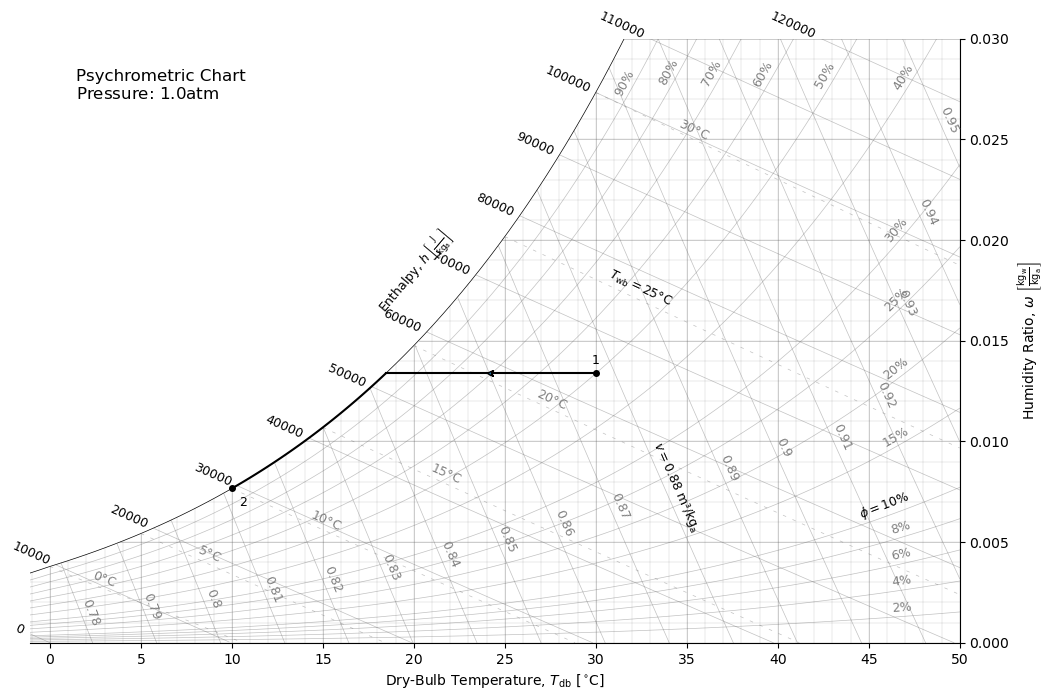

In [22]:
psych = humidair.psychrometric_chart()
psych.plot_state(states[1])
psych.plot_state(states[2],label_loc='south east')
psych.plot_process(states[1],states[2],path='simple cooling')
;

## Equation Formatting
Simply arriving at the correct answer for a problem is only half the battle.  You then need to be able to communicate your methods and results to a range of audiences.  This should be done using technical writing conventions with a narrative discussion of your process including properly formatted equations and sample calculations.  It is not sufficient to simply submit your code and a final numerical answer or a long list of equations without any explanation.

Throughout your academic career you have learned many different conventions (shorthand) for writing down mathematical concepts, i.e. to show a variable is being raised to a power we put that power in the superscript $x^2$.  However, there is no key on your keyboard to make that 2 shrink in size and move above the variable.  You'll also notice that the $x$ was not written in the same font as the rest of the text.  It is convention for variables to be written in italics rather than normal font because it helps the reader quickly recognize variables (you probably already do this in your head without realizing it).

There are a few ways to create properly formatted equations.  While the Microsoft equation editor has improved greatly in recent years, the most powerful tool is the formatting language $\LaTeX$.  $\LaTeX$ has been around for many decades and it was developed to represent complex mathematical expressions using plain text (just the keys on a regular keyboard).  While there is a bit of a learning curve if you choose to start using $\LaTeX$, your efforts will pay off many times over as you will find that most scientific/mathematical software has $\LaTeX$ support built in.

The Jupyter notebook this document is being created in has built-in $\LaTeX$ support.  In some of the earlier examples you may have noticed special symbols in some of the output, such as $\Delta^\circ\text{C}$.  Those were created using $\LaTeX$ formatting and the special symbols in this explanation were also created using $\LaTeX$ formatting (if you are reading this in a live notebook, double-click on this cell to see the source code written in Markdown syntax).  You can include inline math, $f(x)=5x^2-3x+2$, or you can include "display" math 
$$f(x) = \int_0^\infty\frac{3}{2}x\ dx$$

To help you convert your calculations into technical writing format, the `kilojoule` library provides a few convenience functions to automate the $\LaTeX$ creation process.  The `display.Calculations()` class will trigger a process that attempts to convert the code in the current cell to $\LaTeX$ and show the progression of the calculations from symbolic to final numerical form.

To demonstrate the use of `display.Calculations()` we'll step through the evaluation and display of the function $\psi=ax+b-c$.  We'll start by defining values for `a`, `b`, and `x`

In [23]:
from kilojoule import display

In [24]:
a = Quantity(3.2,'psi')
b = Quantity(1,'kPa')
x = 2

display.Calculations();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In this example, the lines defining `a`, `b`, and `x` were simple definitions involving no mathematical operations, so they are shown in simple form.  By placing the line `display.Calculations(locals());` at the end of the cell, we trigger a sequence where the code in the cell is parsed for strings of letters resembling equations and displays them with $\LaTeX$ formatting.  Passing `locals()` as an argument to `display.Calculations()` allows the values from the "local" namespace to be used for substitution when evaluating the expression.

In the next cell we will define `c` as being equal to `a`. 

In [25]:
c = a

display.Calculations();

<IPython.core.display.Latex object>

In this example, we see 3 terms rather than two.  This line still has no mathematical operations, but there is a train of logic where we are setting $c$ equal to $a$.  While it is important to show the numerical value of $c$ as being $3.2\ \mathrm{psi}$, it is also important (possibly more important) to show the process that led to $c$ having that value, so we show the symbolic form of the expression $c=a$ as well.

Let's now evaluate a full equation with mathematical operations.

In [26]:
psi = a*x+b -c

display.Calculations();

<IPython.core.display.Latex object>

In this example the equation is expressed in 3 lines.  The first line shows the symbolic form of the equation, which shows the reader the process or logic that is being applied.  The second line shows numerical values in place of each symbol, which shows the propagation of information from earlier calculations.  Finally the third line shows the numerical value resulting from the calculation.  Note: this is the same form you should use when writing out calculations by hand.  Also, notice that the variable name `psi` was recognized as being a Greek letter and converted to the $\LaTeX$ equivalent of `\psi`.  This will work for most cases if your define your variable names carefully.

Using the `display.Calculations(locals());` command will allow you to properly format your calculations, but you will still need to provide a narrative discussion to describe your process to the reader.  You can do this in a Jupyter notebook by interspersing `Markdown` like this one between your equations, or you can place your narrative in your code as comments that will be shown in your output using the `comments=True` option for the `display.Calculations()` class.

In [27]:
# You can place comments in your code to describe your process.
# For instance, let's calculate the amount of heat transfer required to decrease the temperature of air from 400 K to 300 K in a constant pressure process assuming constant specific heat.  We can start by defining some known parameters, 
T_1 = Quantity(400,'K')
T_2 = Quantity(300,'K')
c_p = Quantity(1.005,'kJ/kg/K')

# We can then solve the first law for $Q$ and substitute $c_p\Delta T$ for $\Delta h$
Q_1_to_2 = c_p*(T_2-T_1)

calcs = display.Calculations();

 You can place comments in your code to describe your process.

 For instance, let's calculate the amount of heat transfer required to decrease the temperature of air from 400 K to 300 K in a constant pressure process assuming constant specific heat.  We can start by defining some known parameters, 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 We can then solve the first law for $Q$ and substitute $c_p\Delta T$ for $\Delta h$

<IPython.core.display.Latex object>

You may have noticed that in the example above, we were apparently storing the result of `display.Calculations()` in a variable `calcs`.  This serves two purposes. It prevents an extra, unnecessary, line from being added to the end of our output, and it also gives us access to the $\LaTeX$ used to generate the output, which can be accessed at `calcs.output`.  This can be useful if you are learning $\LaTeX$ and want to see how an equation for created or if you want take $\LaTeX$ for inclusion in another document.

In [28]:
print(calcs.output)

 You can place comments in your code to describe your process.<br/> For instance, let's calculate the amount of heat transfer required to decrease the temperature of air from 400 K to 300 K in a constant pressure process assuming constant specific heat.  We can start by defining some known parameters, <br/>\[
  \begin{aligned}
    { T_{1} }&={ \left( 400\,\mathrm{K} \right) } = { 400\ \mathrm{K}  }
  \end{aligned}
\]
\[
  \begin{aligned}
    { T_{2} }&={ \left( 300\,\mathrm{K} \right) } = { 300\ \mathrm{K}  }
  \end{aligned}
\]
\[
  \begin{aligned}
    { c_{p} }&={ \left( 1.005\,\frac{\mathrm{kJ}}{\left(\mathrm{K} \cdot \mathrm{kg}\right)} \right) } = { 1.005\ \frac{\mathrm{kJ}}{\left(\mathrm{K} \cdot \mathrm{kg}\right)}  }
  \end{aligned}
\]
 We can then solve the first law for $Q$ and substitute $c_p\Delta T$ for $\Delta h$<br/>\[
  \begin{aligned}{ Q_{1\to{}2} }&={ c_{p} \left(T_{2} - T_{1}\right) }\\
    &={ \left( 1.005\ \frac{\mathrm{kJ}}{\left(\mathrm{K} \cdot \mathrm{kg}\right)

The `kilojoule` library also provides a quick way to show the current value of all the quantities and property tables defined in the local namespace using the `display.Summary()` class, just the quantities using `display.Quantities()`, or just the property tables using `display.PropertyTables()`

In [29]:
display.Summary(n_col=4);

<IPython.core.display.Latex object>

,T,p,v,h,h_w,s,T_wb,T_dp,rel_hum,omega
unit,°C,kPa,m³/kg_a,kJ/kg_a,Btu/lb_water,kJ/K/kg_a,°C,°C,,kg_water/kg_a
1,30,101.325,0.876956,64.355677,-,0.228260,22.000878,-,0.5,0.013373
2,10,101.325,0.811596,29.354502,18.1079,0.107866,10.000000,10,1.0,0.007663


In [30]:
display.Quantities(n_col=6);

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
display.PropertyTables();